In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import re
import warnings
from unidecode import unidecode
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [46]:
### Import data

data = pd.read_excel('/Users/aladelca/Library/CloudStorage/OneDrive-McGillUniversity/MMA/Data mining and visualization/individual_assignment/data/Kickstarter.xlsx')
data.head()

### Filtering only failed and successful

df = data[data['state'].isin(['failed','successful'])]
print(df.shape)
df.columns

(13435, 45)


Index(['id', 'name', 'goal', 'pledged', 'state', 'disable_communication',
       'country', 'currency', 'deadline', 'state_changed_at', 'created_at',
       'launched_at', 'staff_pick', 'backers_count', 'static_usd_rate',
       'usd_pledged', 'category', 'spotlight', 'name_len', 'name_len_clean',
       'blurb_len', 'blurb_len_clean', 'deadline_weekday',
       'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday',
       'deadline_month', 'deadline_day', 'deadline_yr', 'deadline_hr',
       'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr',
       'state_changed_at_hr', 'created_at_month', 'created_at_day',
       'created_at_yr', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days'],
      dtype='object')

In [232]:
AVAILABLE_VARS = ['id','name','goal','pledged','state','disable_communication','country','currency','deadline','created_at','launched_at','staff_pick','backers_count','static_usd_rate','usd_pledged','category','spotlight','name_len','name_len_clean','blurb_len','blurb_len_clean','deadline_weekday','created_at_weekday','launched_at_weekday','deadline_month','deadline_day','deadline_yr','deadline_hr','created_at_month','created_at_day','created_at_yr','created_at_hr','launched_at_month','launched_at_day','launched_at_hr','create_to_launch_days','launch_to_deadline_days']
df['state'].value_counts()
data_av = df[AVAILABLE_VARS]

### Feature engineering

data_av['goal_usd'] = data_av['goal'] * data_av['static_usd_rate']
#data_av['diff_pledged_goal_usd'] = data_av['usd_pledged'] - data_av['goal_usd']
#data_av['pledged_per_backer'] = data_av['usd_pledged'] / data_av['backers_count']
#data_av['pledged_per_backer_goal'] = data_av['usd_pledged'] / data_av['goal_usd']
#data_av['pledged_per_backer_goal_diff'] = data_av['pledged_per_backer'] - data_av['pledged_per_backer_goal']
data_av['category'] = data_av['category'].fillna('unknown') 
goal_category_yr = data_av.groupby(['created_at_yr','category'])['goal_usd'].agg(['mean','max','min',np.std]).reset_index()
goal_category_yr = goal_category_yr.rename(columns = {'mean':'goal_usd_cat_mean','max':'goal_usd_cat_max','min':'goal_usd_cat_min','std':'goal_usd_cat_std'})
data_cat = data_av.merge(goal_category_yr, on = ['created_at_yr','category'], how = 'left')
data_cat = data_cat.sort_values(['currency','created_at'], ascending=False)
data_cat['change_usd_rate'] = data_cat.groupby(['currency'])['static_usd_rate'].pct_change(1)
data_cat['change_usd_rate'] = data_cat['change_usd_rate'].fillna(0)
#data_cat[['pledged_per_backer','pledged_per_backer_goal_diff']] = data_cat[['pledged_per_backer','pledged_per_backer_goal_diff']].fillna(0)
data_cat['goal_usd_cat_mean'] = data_cat['goal_usd_cat_mean'].transform(lambda x: x.fillna(x.mean()))
data_cat['goal_usd_cat_max'] = data_cat['goal_usd_cat_max'].transform(lambda x: x.fillna(x.max()))
data_cat['goal_usd_cat_min'] = data_cat['goal_usd_cat_min'].transform(lambda x: x.fillna(x.min()))
data_cat['goal_usd_cat_std'] = data_cat['goal_usd_cat_std'].transform(lambda x: x.fillna(x.std()))



data_cat['clean_name'] = data_cat['name'].transform(lambda x: handle_text(x))

In [230]:
def handle_text(text):
    text = str(text)
    text = unidecode(text)
    text = text.lower()
    text = re.sub(r'[^\w]', ' ', text)
    return text

In [234]:
from sklearn.model_selection import train_test_split

x = data_cat[['name','clean_name', 'goal', 
       'country', 'currency', 'deadline', 'created_at', 'launched_at',
       'staff_pick', 'backers_count', 'static_usd_rate', 
       'category', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len',
       'blurb_len_clean', 'deadline_weekday', 'created_at_weekday',
       'launched_at_weekday', 'deadline_month', 'deadline_yr',
       'deadline_hr', 'created_at_month', 'created_at_day', 'created_at_yr',
       'created_at_hr', 'launched_at_month', 'launched_at_day',
       'launched_at_hr', 'create_to_launch_days', 'launch_to_deadline_days',
       'goal_usd', 
       'goal_usd_cat_mean', 'goal_usd_cat_max', 'goal_usd_cat_min',
       'goal_usd_cat_std', 'change_usd_rate']]
y = data_cat[['state']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)


In [235]:
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

enc = ce.BinaryEncoder(cols = ['category'])
x_train_final = pd.concat([x_train, enc.fit_transform(x_train['category'])], axis = 1)
x_test_final = pd.concat([x_test,enc.transform(x_test['category'])], axis = 1)


In [254]:
from sklearn.feature_extraction.text import TfidfVectorizer


vect = TfidfVectorizer(stop_words='english', max_features=50, ngram_range=(3,3))
x_train_text = pd.DataFrame(vect.fit_transform(x_train_final['clean_name']).toarray(), columns = vect.get_feature_names_out(), index = x_train_final.index)
x_test_text = pd.DataFrame(vect.transform(x_test_final['clean_name']).toarray(), columns = vect.get_feature_names_out(), index = x_test_final.index)
x_train_df = pd.concat([x_train_text, x_train_final], axis = 1)
x_test_df = pd.concat([x_test_text, x_test_final], axis = 1)
x_test_df

,5v sensor connection,aeur worldaeur tm,arduino compatible board,arduino compatible platform,array wind turbine,axially spiraled wire,board raspberry pi,card raspberry pi,create mobile apps,drones collateral damage,edinburgh festival fringe,edinburgh fringe 2014,edinburgh fringe 2015,edinburgh fringe festival,enclosure lcd keypad,fringe festival 2014,fringe festival 2015,goes edinburgh fringe,high school robotics,identity media filter,imaginary marching band,international fringe festival,kit raspberry pi,little shop horrors,love perfect change,mage create mobile,midsummer night dream,mini arcade cabinet,new social network,open source cnc,open source laser,open source robot,planchette works ouija,power raspberry pi,raspberry pi arduino,raspberry pi beaglebone,raspberry pi camera,raspberry pi zero,shield raspberry pi,smart home automation,social media app,social media website,solar array wind,spiraled wire twisted,tha ac tre,uav drones collateral,usb battery backup,usb flash drive,virtual reality headset,worldaeur tm wearable,name,clean_name,goal,country,currency,deadline,created_at,launched_at,staff_pick,backers_count,static_usd_rate,category,spotlight,name_len,name_len_clean,blurb_len,blurb_len_clean,deadline_weekday,created_at_weekday,launched_at_weekday,deadline_month,deadline_yr,deadline_hr,created_at_month,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_hr,create_to_launch_days,launch_to_deadline_days,goal_usd,goal_usd_cat_mean,goal_usd_cat_max,goal_usd_cat_min,goal_usd_cat_std,change_usd_rate,category_0,category_1,category_2,category_3,category_4
9457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TAGTROC - Free Exchange Social Network,tagtroc free exchange social network,100000.0,CA,CAD,2014-08-29 11:29:22,2014-07-25 08:41:45,2014-07-30 11:29:22,False,0,0.925561,Web,False,6.0,6.0,18.0,11.0,Friday,Friday,Wednesday,8,2014,11,7,25,2014,8,7,30,11,5,30,92556.084,172185.987276,1.000000e+08,20.000000,3.344392e+06,0.005216,0,0,1,1,0
249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Press For Success: WordPress Beyond the Build,press for success wordpress beyond the build,34500.0,US,USD,2016-03-02 10:31:11,2016-01-28 08:19:58,2016-02-01 10:31:11,False,6,1.000000,Web,False,7.0,6.0,20.0,14.0,Wednesday,Thursday,Monday,3,2016,10,1,28,2016,8,2,1,10,4,30,34500.000,44799.906785,1.000000e+06,25.000000,1.265092e+05,0.000000,0,0,1,1,0
6319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,XEUS FLASHLIGHTS Solar Capacitor LED Waterproo...,xeus flashlights solar capacitor led waterproo...,2000.0,US,USD,2015-03-04 15:43:20,2015-01-16 13:34:16,2015-02-02 15:43:20,False,189,1.000000,Gadgets,True,8.0,8.0,13.0,13.0,Wednesday,Friday,Monday,3,2015,15,1,16,2015,13,2,2,15,17,30,2000.000,65363.924060,1.000000e+07,1.000000,3.991640e+05,0.000000,0,0,1,0,1
748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fair Play,fair play,14440.0,US,USD,2016-01-14 21:09:34,2015-10-20 16:37:19,2015-12-15 21:09:34,False,26,1.000000,Plays,False,2.0,2.0,25.0,15.0,Thursday,Tuesday,Tuesday,1,2016,21,10,20,2015,16,12,15,21,56,30,14440.000,7879.146143,2.500000e+05,150.000000,2.109026e+04,0.000000,0,1,0,0,1
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Start a Web Design & Web develo

In [288]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

VARS = ['goal_usd','staff_pick','blurb_len_clean','name_len_clean','deadline_month', 'deadline_yr','launched_at_month', 'launched_at_day',
       'launched_at_hr',
       'goal_usd_cat_mean', 'goal_usd_cat_max', 'goal_usd_cat_min','category_0','category_1','category_2','category_3','category_4',
       'goal_usd_cat_std','change_usd_rate','create_to_launch_days', 'launch_to_deadline_days'] #+ list(vect.get_feature_names_out())
best_params = {'learning_rate': 0.003986546509987633,
 'n_estimators': 7148,
 'max_depth': 4,
 'min_samples_split': 9,
 'min_samples_leaf': 4,
 'max_features': 3,
 'subsample': 0.37033067681152226}
best_params_rf = {'criterion': 'entropy',
 'n_estimators': 6237,
 'max_depth': 16,
 'min_samples_split': 2,
 'min_samples_leaf': 7}
#model =GradientBoostingClassifier(**best_params, random_state = 123)
model = HistGradientBoostingClassifier(max_iter =100000, max_depth = 5,random_state = 123)
#model = RandomForestClassifier(**best_params_rf, random_state = 123)
model.fit(x_train_df[VARS], y_train)

preds = model.predict(x_test_df[VARS])

preds_proba = model.predict_proba(x_test_df[VARS]) 
accuracy_score(y_test, preds)

0.7737253442500931

In [282]:
from sklearn.metrics import accuracy_score
import optuna
def objective(trial):
    '''
    params = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1),
              'n_estimators':trial.suggest_int('n_estimators', 100, 10000),
              'max_depth':trial.suggest_int('max_depth', 1, 15),
              'min_samples_split':trial.suggest_int('min_samples_split', 2, 10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 10),
              'max_features':trial.suggest_int('max_features', 1, 15),
              'subsample':trial.suggest_uniform('subsample', 0.1, 1.0),
              }
    
    params = {'criterion':trial.suggest_categorical('criterion', ['gini', 'entropy','log_loss']),
              'n_estimators':trial.suggest_int('n_estimators', 100, 10000),
              'max_depth':trial.suggest_int('max_depth', 1, 16),
              'min_samples_split':trial.suggest_int('min_samples_split', 2, 10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 10),
              
        
              }
    '''
    params = {'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1),
              'max_iter':trial.suggest_int('max_iter', 100, 10000),
              'max_depth':trial.suggest_int('max_depth', 1, 15),
              'max_leaf_nodes':trial.suggest_int('max_leaf_nodes', 1, 100),}
    #params_t = {'threshold':trial.suggest_float('threshold', 0.0, 1.0)}
    #threshold = params_t['threshold']
    model =HistGradientBoostingClassifier(**params, random_state=123)
    model.fit(x_train_final[VARS], y_train)
    #preds_proba = model.predict_proba(x_test_final[VARS])
    #preds = np.where(preds_proba[:,1]>= threshold, 1, 0)
    preds = model.predict(x_test_final[VARS])
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [283]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print(study.best_trial)

[I 2023-11-30 01:09:17,418] A new study created in memory with name: no-name-e945d84c-7351-45b1-8649-354143942cbd
[W 2023-11-30 01:19:26,945] Trial 0 failed with parameters: {'learning_rate': 9.647996996805722e-05, 'max_iter': 8258, 'max_depth': 10, 'max_leaf_nodes': 42} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/aladelca/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/3s/3k3nlxhn13nfv9vncl9g9kbr0000gn/T/ipykernel_1823/436672285.py", line 30, in objective
    model.fit(x_train_final[VARS], y_train)
  File "/Users/aladelca/Library/Python/3.9/lib/python/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/aladelca/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 696, in fit
    grower.grow()
  File "

KeyboardInterrupt: 

In [183]:
study.best_params

{'criterion': 'entropy',
 'n_estimators': 6237,
 'max_depth': 16,
 'min_samples_split': 2,
 'min_samples_leaf': 7}

<Axes: >

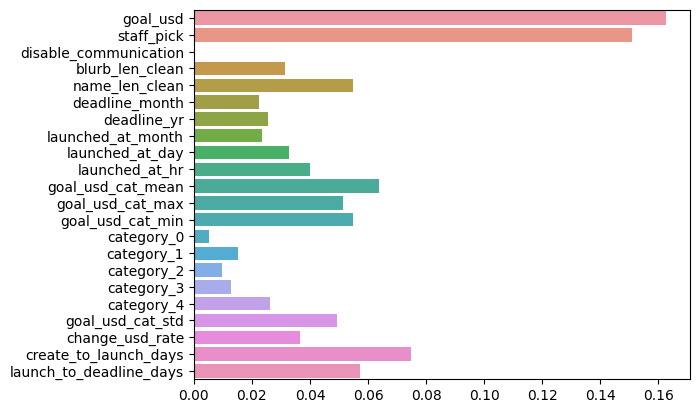

In [177]:
sns.barplot(x = model.feature_importances_, y = VARS)

In [277]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
model =GradientBoostingClassifier(**best_params, random_state=123)
model = HistGradientBoostingClassifier( random_state = 123)
#model = RandomForestClassifier(**best_params_rf, random_state=123)
cv_results = cross_validate(model, x_train_df[VARS], y_train, cv=5, return_train_score=True)

In [278]:
cv_results

{'fit_time': array([11.6406889 , 13.56741929, 17.37272882, 15.4772222 , 15.94751811]),
 'score_time': array([0.05698299, 0.06526303, 0.31647396, 0.30858278, 0.83987594]),
 'test_score': array([0.78697674, 0.78465116, 0.7827907 , 0.77152164, 0.77291764]),
 'train_score': array([0.8783438 , 0.87950686, 0.87915794, 0.87649727, 0.8790557 ])}